## Telluric fitting

Uses specutils, jovispec 

To install specutils and JoviSpec, run the following commands

```sh
pip install specutils
git clone https://github.com/HajimeKawahara/jovispec.git
cd jovispec
python setup.py install
``````

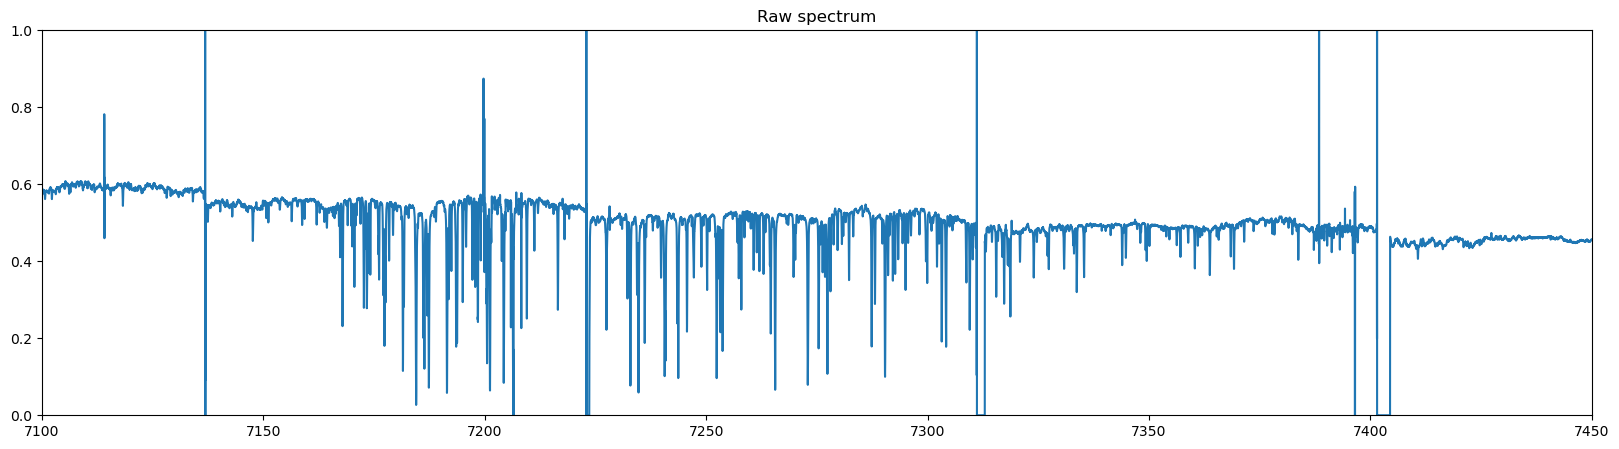

In [1]:
from jovispec import abcio
import pkg_resources

jupiter_data = pkg_resources.resource_filename("jovispec", "jupiter_data")

# blue
rlamb2, rspec2, rhead = abcio.read_qfits("06002", jupiter_data, ext="q")  # WASP33b
rlamb3, rspec3, rhead = abcio.read_qfits("06004", jupiter_data, ext="q")  # WASP33b
rlamb4, rspec4, rhead = abcio.read_qfits("06006", jupiter_data, ext="q")  # WASP33b
rlamb5, rspec5, rhead = abcio.read_qfits("06008", jupiter_data, ext="q")  # WASP33b
rlamb = rlamb2
rspec = rspec2 + rspec3 + rspec4 + rspec5

wavelength_start = 7100.0  # AA
wavelength_end = 7450.0  # AA

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 5))
plt.plot(rlamb, rspec)
plt.ylim(0.0, 1.0)
plt.xlim(wavelength_start, wavelength_end)
plt.title("Raw spectrum")
plt.show()

In [2]:
from specutils.utils.wcs_utils import refraction_index
import astropy.units as u

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# mask some bad regions... as usual in astronomy  
mask_wav = [
[7114.0,7114.2],
[7136.8, 7137.0],
[7199.0,7200.0],
[7205.8,7206.0],
[7206.25,7206.75],
[7208.2,7208.4],
[7222.8,7224.0],
[7311.0,7313.],
[7388.3,7388.5],
[7396.4,7396.6],
[7401.0,7405.0]
]
rlamb = np.array([float(d) for d in rlamb])
mask_index=np.digitize(mask_wav,rlamb)
for ind in mask_index:
    rspec[ind[0]:ind[1]+1] = None


# None for outside wvelength start - end region
start_index=np.digitize(wavelength_start,rlamb)
end_index=np.digitize(wavelength_end,rlamb)
rspec[:start_index] = None
rspec[end_index:] = None

#Air-Vaccum correction
mask = rspec == rspec
rlamb = rlamb[mask]
rspec = rspec[mask]
nair = refraction_index(rlamb*u.AA,method="Ciddor1996")
rlamb = rlamb*nair

# ascending wavenumber form
from exojax.spec.unitconvert import wav2nu
rlamb = rlamb[::-1]
nus_obs = wav2nu(rlamb, unit="AA")
rspec = rspec[::-1]

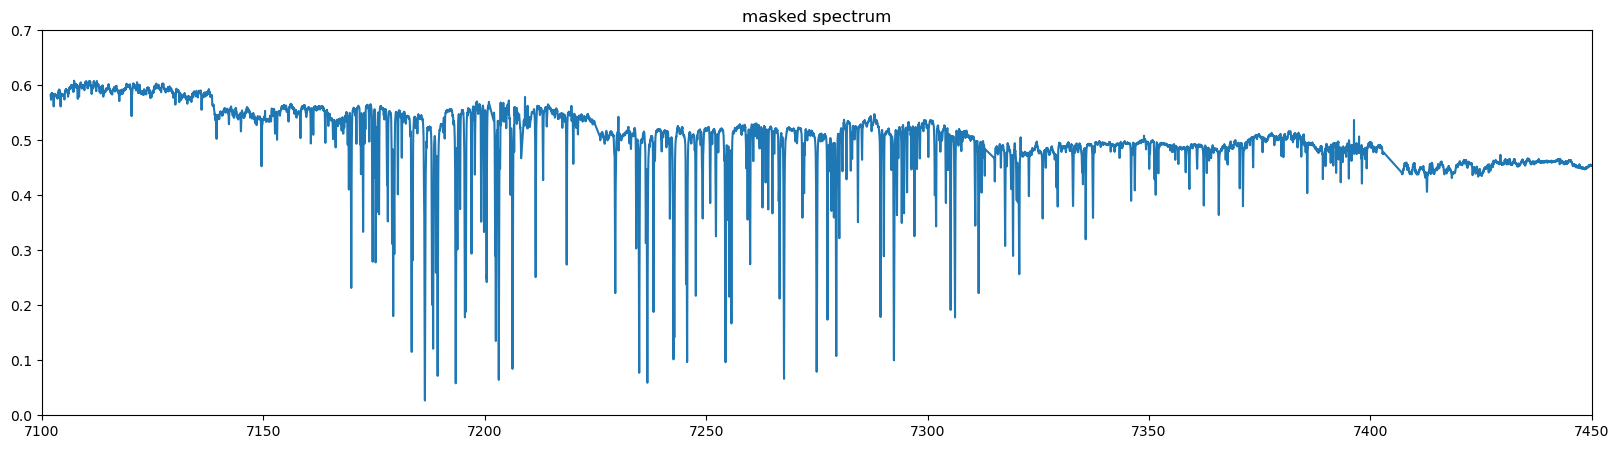

In [5]:
fig = plt.figure(figsize=(20,5))
plt.plot(rlamb,rspec)
plt.ylim(0.0,0.7)
plt.xlim(wavelength_start, wavelength_end)
#plt.xlim(7205,7207)

plt.title("masked spectrum")
plt.show()

In [7]:
wavelength_start = 7100.0  # AA
wavelength_end = 7450.0  # AA
from exojax.spec.api import MdbHitran
from exojax.spec.opacalc import OpaDirect
from exojax.spec.opacalc import OpaPremodit
from exojax.utils.grids import wavenumber_grid
from exojax.spec.unitconvert import wav2nu

N = 40000

margin = 10  # cm-1
nus_start = wav2nu(wavelength_end, unit="AA") - margin
nus_end = wav2nu(wavelength_start, unit="AA") + margin
#nus_start = 1.e8/wavelength_end - margin
#nus_end = 1.e8/wavelength_start + margin

mdb_water = MdbHitran("H2O", nurange=[nus_start, nus_end], isotope=1)
nus, wav, res = wavenumber_grid(nus_start, nus_end, N, xsmode="lpf", unit="cm-1")
# opa = OpaDirect(mdb_water, nu_grid=nus)
opa = OpaPremodit(mdb_water, nu_grid=nus, allow_32bit=True, auto_trange=[150.0, 300.0])

xsmode =  lpf
xsmode assumes ESLOG in wavenumber space: mode=lpf
We changed the policy of the order of wavenumber/wavelength grids
wavenumber grid should be in ascending order and now 
users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
This might causes the bug if you update ExoJAX. 
Note that the older ExoJAX assumes ascending order as wavelength grid.
OpaPremodit: params automatically set.
Robust range: 148.362692491353 - 337.48243799560873 K
Change the reference temperature from 296.0K to 163.08464046497667 K.


/home/kawahara/exojax/src/exojax/utils/jaxstatus.py:19: UserWarning: JAX is 32bit mode. We recommend to use 64bit mode. 
You can change to 64bit mode by writing 

    from jax import config 
    config.update("jax_enable_x64", True)

  warnings.warn(msg+how_change_msg)
/home/kawahara/exojax/src/exojax/spec/set_ditgrid.py:52: UserWarning: There exists negative or zero value.
  warnings.warn("There exists negative or zero value.")


OpaPremodit: Tref_broadening is set to  212.1320343559642 K
OpaPremodit: gamma_air and n_air are used. gamma_ref = gamma_air/Patm
# of reference width grid :  18
# of temperature exponent grid : 4


uniqidx: 100%|██████████| 29/29 [00:00<00:00, 3195.20it/s]

Premodit: Twt= 282.92333337743037 K Tref= 163.08464046497667 K
Making LSD:|--------------------| 0%

Making LSD:|####################| 100%


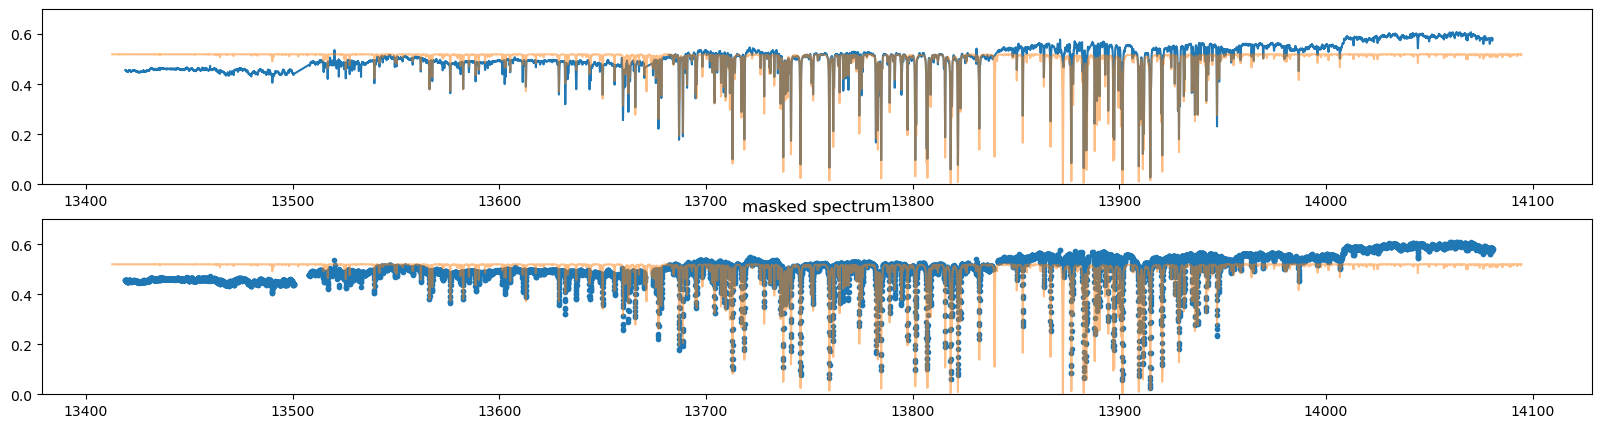

In [8]:
import jax.numpy as jnp

T = 200.0
P = 0.5
xsv = opa.xsvector(T, P)
nl = 2.0e22
a = 0.52

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(211)
plt.plot(nus_obs, rspec)
plt.ylim(0.0, 0.7)
plt.plot(nus, a * jnp.exp(-nl * xsv), alpha=0.5)
# plt.xlim(1.e8/wavelength_start, 1.e8/wavelength_end)

ax = fig.add_subplot(212)
plt.plot(nus_obs, rspec, ".")
plt.plot(nus, 0.52 * jnp.exp(-nl * xsv), alpha=0.5)
plt.ylim(0.0, 0.7)

# plt.xlim(1.e8/7200,1.e8/7250)

plt.title("masked spectrum")
plt.show()

## Zero-th order Fitting 
i.e. single temperature/pressure model of the water absorption and no trend correction

In [9]:
T_b = 200.0
P_b = 0.5
nl_b = 2.0e22
a_b = 0.52
initial_guess = np.array([T_b, P_b, nl_b, a_b])
initpar = np.ones_like(initial_guess)

In [10]:
# instrumental setting
from exojax.spec.specop import SopInstProfile
from exojax.utils.instfunc import resolution_to_gaussian_std

Rinst = 160000.0
beta_inst = resolution_to_gaussian_std(Rinst)
sop_inst = SopInstProfile(nus, res)


def model(params):
    T, P, nl, a = params * initial_guess
    xsv = opa.xsvector(T, P)
    trans = a * jnp.exp(-nl * xsv)
    Frot_inst = sop_inst.ipgauss(trans, beta_inst)
    mu = sop_inst.sampling(Frot_inst, 0.0, nus_obs)
    return mu

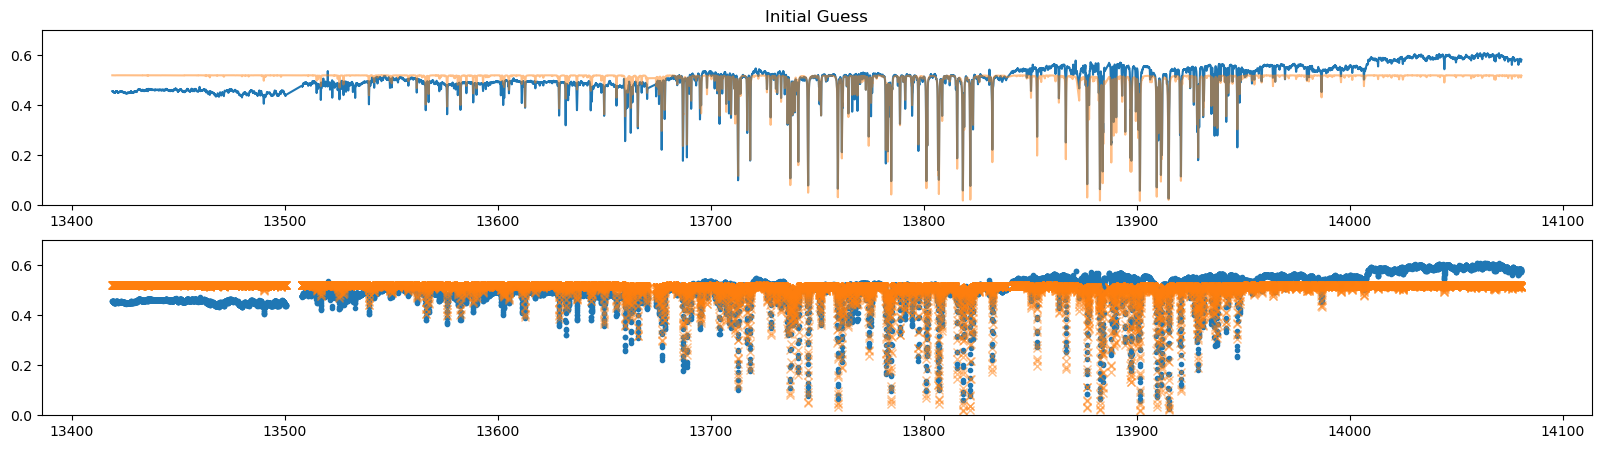

In [11]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(211)
plt.title("Initial Guess")
plt.plot(nus_obs,rspec)
plt.ylim(0.0,0.7)
plt.plot(nus_obs,model(np.ones(4)),alpha=0.5)
#plt.xlim(1.e8/wavelength_start, 1.e8/wavelength_end)

ax = fig.add_subplot(212)
plt.plot(nus_obs,rspec,".")
plt.plot(nus_obs,model(np.ones(4)),"x",alpha=0.5)
plt.ylim(0.0,0.7)

#plt.xlim(1.e8/7200,1.e8/7250)

plt.show()


In [12]:
def objective(params):
    f=rspec-model(params)
    return jnp.dot(f,f)*1.e-6

In [13]:
import jaxopt
from jaxopt import OptaxSolver
import optax


#gd = jaxopt.GradientDescent(fun=objective, maxiter=1000, stepsize=1.0)
#res = gd.run(init_params=initpar)
#params, state = res

import tqdm
adam = OptaxSolver(opt=optax.adam(1.e-3), fun=objective)
state = adam.init_state(initpar)
params_a=np.copy(initpar)

params_adam=[]
Nit=300
for _ in  tqdm.tqdm(range(Nit)):
    params_a,state=adam.update(params_a,state)
    params_adam.append(params_a)

params = params_adam[-1]
print(params*initial_guess)

100%|██████████| 300/300 [00:11<00:00, 26.90it/s]

[2.4120670e+02 4.8870286e-01 1.9894836e+22 5.1787055e-01]


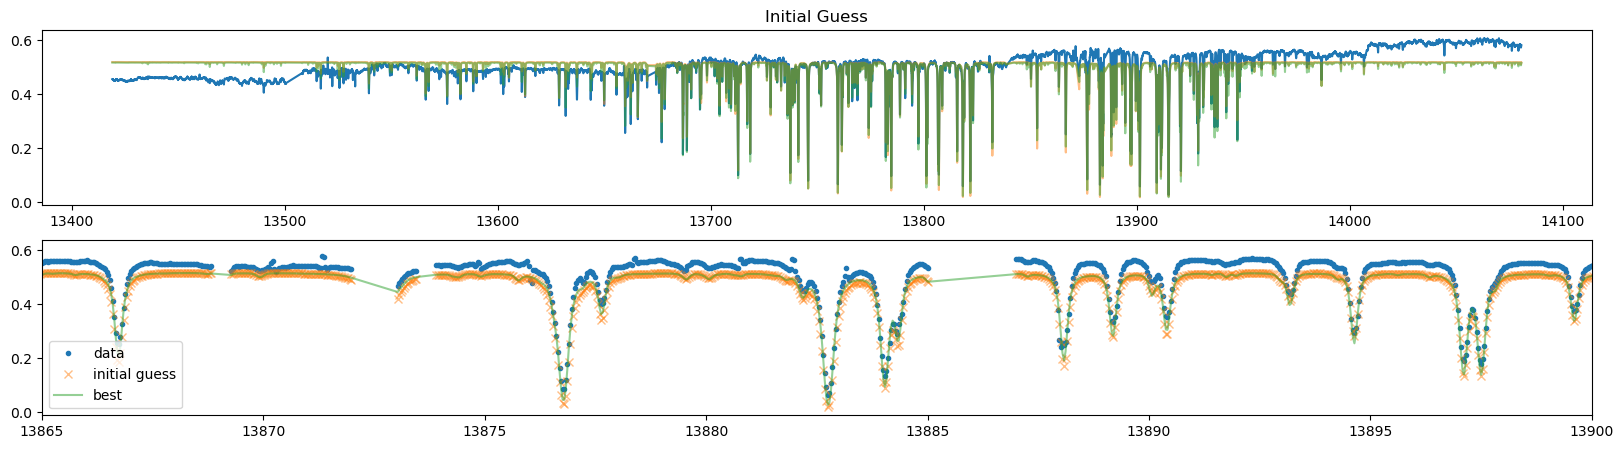

In [14]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(211)
plt.title("Initial Guess")
plt.plot(nus_obs,rspec)
plt.plot(nus_obs,model(np.ones(4)),alpha=0.5)
plt.plot(nus_obs,model(params),alpha=0.5)
ax = fig.add_subplot(212)
plt.plot(nus_obs,rspec,".", label="data")
plt.plot(nus_obs,model(np.ones(4)),"x",alpha=0.5, label="initial guess")
plt.plot(nus_obs,model(params),alpha=0.5, label="best")
plt.legend()

#plt.xlim(1.e8/7250,1.e8/7200)
plt.xlim(13865,13900)
#plt.xlim(13865,13870)

plt.show()


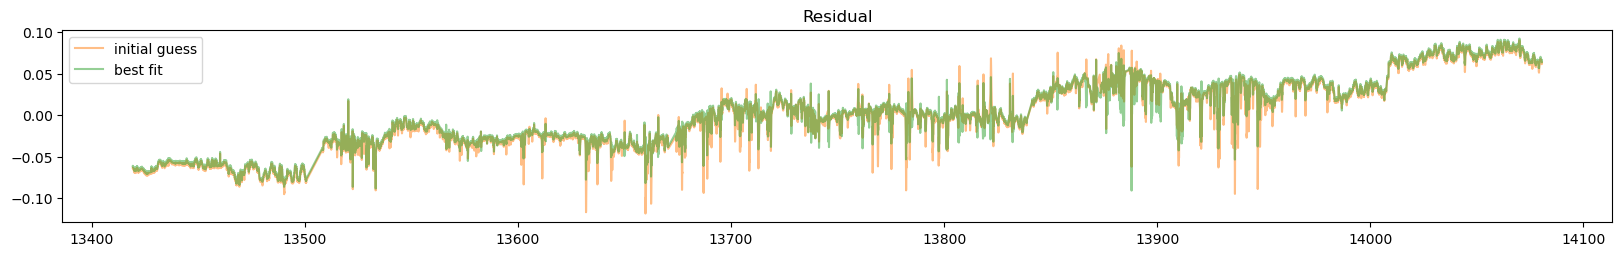

In [16]:
fig = plt.figure(figsize=(20,2.5))
plt.plot(nus_obs,rspec- model(np.ones(4)),alpha=0.5,color="C1", label="initial guess")
plt.plot(nus_obs,rspec - model(params),alpha=0.5,color="C2", label="best fit")
plt.title("Residual")
plt.legend()